# Speech analysis and re-synthesis

This notebook demonstrates how to analyze speech and re-synthesis speech waveform from speech parameters using [pysptk](https://github.com/r9y9/pysptk) (and other useful speech/audio/music analysis packages). Synthesized audio examples are provided so that you are able to compare synthesis filters on your browser. 

Note: this notebook is a modified version of one linked on the [pysptk](https://github.com/r9y9/pysptk) github page.

## Requirements

- pysptk: https://github.com/r9y9/pysptk
- scipy
- librosa: https://github.com/bmcfee/librosa
- seaborn: https://github.com/mwaskom/seaborn

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set(style="dark")
plt.rcParams['figure.figsize'] = (16, 5)

In [2]:
from IPython.display import Audio

In [3]:
import numpy as np
import librosa
import librosa.display
import pysptk
from scipy.io import wavfile

## Data

In [4]:
sr, x = wavfile.read(pysptk.util.example_audio_file())
#sr sampling rate
assert sr == 16000
print(x.shape)

(64000,)


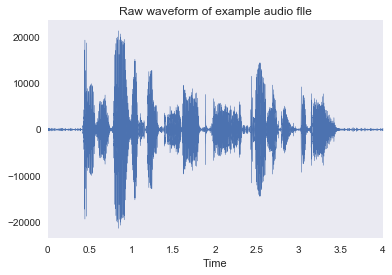

In [6]:
librosa.display.waveplot(np.array(x, dtype=np.float64), sr=sr)
plt.title("Raw waveform of example audio flle")
Audio(x, rate=sr)

## Source parameter extraction

### Framing and windowing

In [7]:
frame_length = 1024
hop_length = 80

# Note that almost all of pysptk functions assume input array is C-contiguous and np.float4 element type
frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T

# Windowing
frames *= pysptk.blackman(frame_length)

assert frames.shape[1] == frame_length 

### F0 estimation

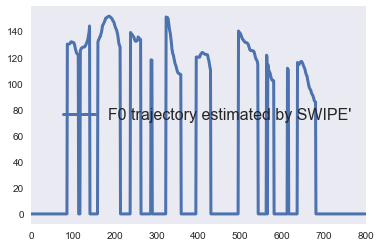

In [9]:
# F0 estimation
f0 = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="f0")
plt.plot(f0, linewidth=3, label="F0 trajectory estimated by SWIPE'")
plt.xlim(0, len(f0))
plt.legend(prop={'size': 16})

## Source excitation generation

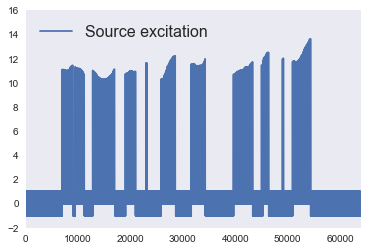

In [10]:
# Note that pysptk.excite assuems input as pitch, not *f0*.
pitch = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="pitch")
source_excitation = pysptk.excite(pitch, hop_length)
                            
plt.plot(source_excitation, label="Source excitation")
plt.xlim(0, len(source_excitation))
plt.ylim(-2, 16)
plt.legend(prop={'size': 16})

In [11]:
# listen to what that sounds like
Audio(source_excitation, rate=sr)

## Synthesis from mel-cepstrum

Text(0.5,1,'Spectral envelope estimate from mel-cepstrum')

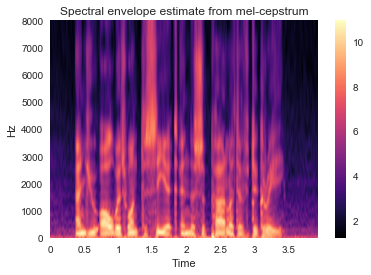

In [12]:
# Order of mel-cepstrum
order = 25
alpha = 0.41

mc = pysptk.mcep(frames, order, alpha)
logH = pysptk.mgc2sp(mc, alpha, 0.0, frame_length).real
librosa.display.specshow(logH.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear")
plt.colorbar()
plt.title("Spectral envelope estimate from mel-cepstrum")

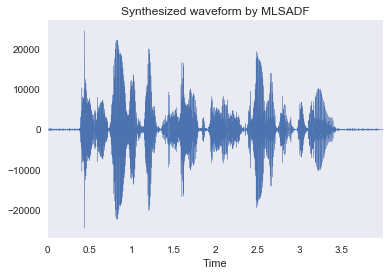

In [14]:
from pysptk.synthesis import MLSADF, Synthesizer

# Convert mel-cesptrum to MLSADF coefficients
b =pysptk.mc2b(mc, alpha);

synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(x_synthesized, sr=sr)
plt.title("Synthesized waveform by MLSADF")
Audio(x_synthesized, rate=sr)

# Some experiments

* We can modify the original pitch track to get different effects
* First scale the pitch by multiplying/dividing by a constant
* Then replace all non-zero pitch values by a constant
* Listen to the result!

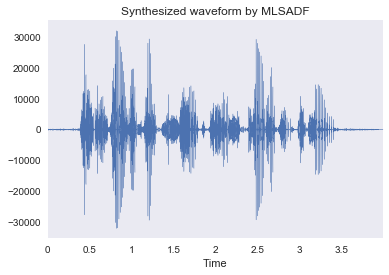

In [16]:
pitch = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="pitch")

# modify the pitch, note that pitch is the wavelength of the sound 
# in samples, so larger pitch is a lower frequency sound
pitch = pitch*2

source_excitation = pysptk.excite(pitch, hop_length)
     
x_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(x_synthesized, sr=sr)
plt.title("Synthesized waveform by MLSADF")
Audio(x_synthesized, rate=sr)

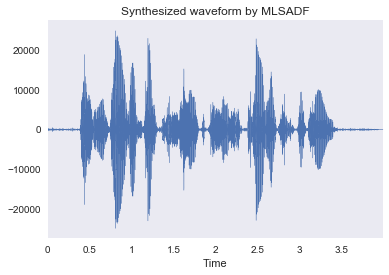

In [18]:
pitch = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="pitch")

# modify the pitch to set it to be a constant value of 130
# first generate an array of True/False to indicate when pitch is > 0 
mask = pitch > 0
# now set those values where pitch > 0 to be 130
pitch[mask] = 130

source_excitation = pysptk.excite(pitch, hop_length)
     
x_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(x_synthesized, sr=sr)
plt.title("Synthesized waveform by MLSADF")
Audio(x_synthesized, rate=sr)

# Resynthesise Yourself

You can use any recording for this exercise, so record your own voice (needs to be recorded at 16KHz sampling frequency) and save it as a WAV file in the same directory as this notebook.  Then load it into the notebook in the __Data__ section at the top, eg.:

In [21]:
sr, x = wavfile.read("chuishunkong.wav")

FileNotFoundError: [Errno 2] No such file or directory: 'chuishunkong.wav'

You can then re-run the notebook from top to bottom to hear your own speech re-synthesised using this method.

__NOTE:__ you may want to look at [Audacity](https://www.audacityteam.org/) for a sound recording tool that let's you control the sample frequency of your recordings.